## FEC Campaign Finance: 

### Contributions from committees to candidates & independent expenditures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy
from matplotlib import font_manager as fm, rcParams
from matplotlib.lines import Line2D
from matplotlib.offsetbox import (
    AnnotationBbox,
    OffsetImage, 
)

%matplotlib inline

In [2]:
year = '2018'

In [3]:
gave = pd.read_csv('data/04a_committee_stats.csv')
mask = [True if ('comm1__' in x) else False for x in gave['name']]
gave1 = gave[mask]
gave1.index = list(gave1['name'].values)

cand = pd.read_csv('data/04a_cand_cleaned.csv')
cands = list(set(cand['cand_id']))
cols = [x for x in list(gave1.columns) if x in cands]
cols.extend(['total', 'count', 'distinct', 'entity_tps'])
gave1 = gave1[['name'] + cols]
print(len(gave1))
gave1.head(2)

1242


,name,H0AL02087,H0AL05163,H0AL07086,H0AR01083,H0AR03055,H0AZ01259,H0CA03078,H0CA10073,H0CA10149,...,S8VT00141,S8WA00194,S8WA00319,S8WI00224,S8WV00143,S8WY00189,total,count,distinct,entity_tps
comm1__WATERFRONT STRATEGIES (against),comm1__WATERFRONT STRATEGIES (against),0,0,0,0,0,0,0,0,0,...,0,0,0,0,8003952,0,215187409,624,77,['enttp_Organization (not a committee and not ...
comm1__NEBO MEDIA (against),comm1__NEBO MEDIA (against),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,106207121,432,48,['enttp_Organization (not a committee and not ...


In [4]:
for col in gave1.columns:
    if gave1[col].sum() == 0:
        gave1.drop([col], axis = 1, inplace = True)
#         print(col)
        print('.', end = '')

................................................................................................................................................

In [5]:
counts = gave1.drop([
    'name', 
    'total', 
    'count', 
    'distinct', 
    'entity_tps',

], axis = 1)

for col in counts.columns:
    counts[col] = [1 if x > 0 else 0 for x in counts[col]]
    
print(len(counts.columns))
counts = counts.sum().sort_values(ascending = False)
counts[:20]

689


S8AZ00197    221
H8AZ08083    152
H8CA45130    127
S8NV00156    125
H8CA48035    110
H8PA18181    102
S6MO00305    100
H8CA39174     97
H8OH12297     95
S6MT00162     95
S6PA00217     92
H8VA07094     87
H8FL26039     85
H8PA04090     84
S6OH00163     84
H8CA25074     82
S2WI00219     79
H8WA08189     77
H2NV04011     76
S8FL00166     75
dtype: int64

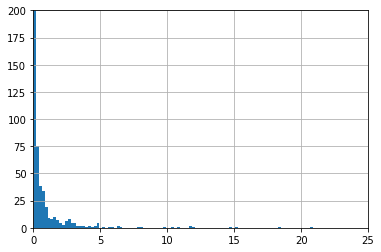

In [15]:
plt.figure()

(gave1['total']/1.0E6).hist(bins = 1000)

plt.xlim([0, 25])
plt.ylim([0, 200])

plt.show();

In [ ]:
plt.figure(figsize = (18, 6))

plt.scatter(
    gave1['distinct'], 
    gave1['total']/1.0E6, 
    s = 10,
)
plt.xlabel('# Distinct Recipients')
plt.ylabel('Total ($MM)')
plt.show();

In [ ]:
std_tot = gave1['total'].std()
med_tot = gave1['total'].median()

std_dist = gave1['distinct'].std()
med_dist = gave1['distinct'].median()

gave1_new = gave1[
    ~(
        (gave1['total'] < 1.*med_tot + 2.*std_tot) & \
        (gave1['distinct'] < 1.*med_dist + 0.*std_dist)
    ) \
#     & (gave1['distinct'] > 10)
]

len(gave1_new)

In [ ]:
gave1_new['distinct'].value_counts().sort_index()

In [ ]:
plt.figure()

plt.scatter(
    gave1_new['distinct'], 
    gave1_new['total']/1.0E6, 
    s = 10,
)
plt.show();

In [ ]:
rows = []
for comm in list(gave1_new.index):
    lil_row = []
    lil_cand = cand[cand[comm] > 0]
    for which in ['Republican', 'Democrat', 'Third party']:    
        liller_cand = lil_cand[lil_cand['cand_pty_affiliation'] == which]
        lil_row.append(liller_cand[comm].sum())
        lil_row.append(len(liller_cand.drop_duplicates(['cand_id'], keep = 'first')))
    rows.append(lil_row)
    
rows = pd.DataFrame(
    rows, 
    columns = [
        'r_amt', 
        'r_count', 
        'd_amt', 
        'd_count',
        't_amt',
        't_count',
    ], 
    index = list(gave1_new['name'].values), 
)

rows.sort_index(inplace = True)
rows.head()

In [ ]:
rows[(rows['r_amt'] != 0) & (rows['d_amt'] != 0)].sort_index()

In [ ]:
rows['cm'] = [x.replace('comm1__', '').replace(' (for)', '').replace(' (against)', '') for x in list(rows.index)]

these = sorted(list(rows['cm'].value_counts()[rows['cm'].value_counts() > 1].index))

these

In [ ]:
def plot_foragainst(this):
    # 'this' (committee) both advocated and opposed
    this_cm = cand.loc[
        (cand[f'comm1__{this} (against)'] >= 0) & \
        (cand[f'comm1__{this} (for)'] >= 0), [
            'cand_id',
            'cand_name',
            'contest',
            'cand_pty_affiliation',
            'cand_ici',
            f'comm1__{this} (for)',
            f'comm1__{this} (against)',
    ]].sort_values(['cand_pty_affiliation', f'comm1__{this} (for)'], ascending = [True, False])
    
    mask = [False if ((this_cm.loc[i, f'comm1__{this} (for)'] == 0) & \
                      (this_cm.loc[i, f'comm1__{this} (against)'] == 0)) else True for i in list(this_cm.index)]
    
    this_cm = this_cm[mask]
    
    this_cm.loc[this_cm[f'comm1__{this} (against)'] == 0, f'comm1__{this} (against)'] = 1
    this_cm.loc[this_cm[f'comm1__{this} (for)'] == 0, f'comm1__{this} (for)'] = 1
    
    max_amt = max(this_cm[f'comm1__{this} (for)'].max(), this_cm[f'comm1__{this} (against)'].max())
    min_amt = min(this_cm[f'comm1__{this} (for)'].min(), this_cm[f'comm1__{this} (against)'].min())

    party_dict = {
            'Republican' : {
                'hex' : '#FF6661', 
                'mult' : 0,#0.3, 
                'party' : 'Republican',
            },
            'Democrat' : {
                'hex' : '#5494F7', 
                'mult' : 0,#-0.3, 
                'party' : 'Democrat',
            },
            'Third party' : {
                'hex' : '#15DCDC',
                'mult' : 0,
                'party' : 'Third party',
            }
        }

    ici_dict = {
        'I' : ['o', 'incumbent'],
        'C' : ['D', 'challenger'],
        'O' : ['+', 'open'],
    }

    vol_light = '#f8fbfc'
    vol_dark = '#263C4D'

    fig = plt.figure(figsize = (8, 8))

    # face/axis colors
    fig.patch.set_facecolor(vol_light)
    ax = fig.add_subplot(111)
    ax.patch.set_facecolor(vol_light)

    vol_dark_rcparams = [
        'patch.edgecolor',
        'grid.color',
        'text.color',
        'axes.labelcolor',
        'xtick.color',
        'ytick.color',
        'axes.edgecolor'
    ]

    for which in vol_dark_rcparams:
        plt.rcParams[which] = vol_dark

    font_dirs = ['../../css/fonts/for_matplotlib/', ]
    font_files = fm.findSystemFonts(fontpaths=font_dirs)
    font_list = fm.createFontList(font_files)
    fm.fontManager.ttflist.extend(font_list)

    plt.rcParams['font.family'] = 'DM Sans Medium'
    
    parties = list(set(this_cm['cand_pty_affiliation']))
    all_icis = list(set(this_cm['cand_ici']))
    
    for pty in parties:
        lil_this_cm = this_cm[this_cm['cand_pty_affiliation'] == pty]
        icis = list(set(lil_this_cm['cand_ici']))
        for ici in icis:
            liller_this_cm = lil_this_cm[lil_this_cm['cand_ici'] == ici]
            alpha = 0.75
            lw = 1.5
            s = 100
            if ici in ['I', 'C']:
                plt.scatter(
                    np.log10(liller_this_cm[f'comm1__{this} (for)']),
                    np.log10(liller_this_cm[f'comm1__{this} (against)']),
                    color = party_dict[pty]['hex'],
                    s = s,
                    lw = lw,
                    alpha = alpha,
                    facecolors = 'none',
                    marker = ici_dict[ici][0],
                )
            else:
                plt.scatter(
                    np.log10(liller_this_cm[f'comm1__{this} (for)']),
                    np.log10(liller_this_cm[f'comm1__{this} (against)']),
                    color = party_dict[pty]['hex'],
                    s = s,
                    lw = lw,
                    alpha = alpha,
                    marker = ici_dict[ici][0],
                )

    plt.title(f'{year} U.S. Congressional Elections:\n{this}\nIndependent Expenditures', fontsize = 18)
    plt.xlabel('\n'.join([r'Log$_{10}$(Total contribution', 'advocating candidate (USD))']), fontsize = 14)
    plt.ylabel('\n'.join([r'Log$_{10}$(Total contribution', 'opposing candidate (USD))']), fontsize = 14)
    plt.plot(
        [0, 1.2*np.log10(max_amt)], 
        [0, 1.2*np.log10(max_amt)], 
        ls = '--', 
        alpha = 0.3, 
        color = vol_dark,
    )
    
    legend_elements = []
    
    if 'Republican' in parties:
        legend_elements.append(
            mpatches.Patch(
                [0], 
                [0], 
                color=party_dict['Republican']['hex'], 
                label='Republican'
            )
        )
    if 'Democrat' in parties:
        legend_elements.append(
            mpatches.Patch(
                [0], 
                [0], 
                color=party_dict['Democrat']['hex'], 
                label='Democrat', 
            )
        )
    if 'Third party' in parties:
        legend_elements.append(
            mpatches.Patch(
                [0], 
                [0], 
                color=party_dict['Third party']['hex'], 
                label='Third party', 
            )
        )
    if 'I' in all_icis:
        legend_elements.append(
            Line2D(
                [0], 
                [0], 
                marker='o', 
                color=vol_light, 
                label='Incumbent', 
                markerfacecolor='#446d8c', 
                markersize=9,
            )
        )
    if 'C' in all_icis:
        legend_elements.append(
            Line2D(
                [0], 
                [0], 
                marker='D', 
                color=vol_light, 
                label='Challenger', 
                markerfacecolor='#446d8c', 
                markersize=9,
            )
        )
    if 'O' in all_icis:
        legend_elements.append(
            Line2D(
                [0], 
                [0], 
                marker='P', 
                color=vol_light, 
                label='Open seat', 
                markerfacecolor='#446d8c', 
                markersize=9,
            )
        )
    legend = plt.legend(
        loc='upper right', 
        fontsize=12, 
        facecolor='#f8fbfc', 
        handles=legend_elements,
    )
    
    x = ax.annotate('Source: FEC.gov', 
                    xy=(0.0, 0.0), 
                    xytext=(38.0, -28.0), 
                    ha='center', 
                    va='bottom', 
                    textcoords='axes pixels', 
                    xycoords='axes pixels',
                   )
    # logo
    arr_img = plt.imread('../../assets/VOL_Logo_Color_Light_Green.png')
    imagebox = OffsetImage(arr_img, zoom=0.07)
    imagebox.image.axes = ax
    xy = (0.0, -45.0)
    ab = AnnotationBbox(imagebox, 
                        xy,
                        xybox=(xy[0], xy[1]),
                        xycoords='axes pixels',
                        boxcoords=('axes pixels'),
                        box_alignment=(0., 0.),
                        frameon=False,
                       )
    ax.add_artist(ab)
    plt.show();
    return this_cm
#     except:
#         print('committee did not both advocate and oppose')
#         return

In [ ]:
for thislet in these:
    print(thislet)
    plot_foragainst(thislet)

In [ ]:
# HUSTLE advocated Republicans
cand.loc[
    (cand['comm1__HUSTLE (for)'] > 0) & \
    (cand['cand_pty_affiliation'] == 'Republican'), [
        'cand_id',
        'cand_name',
        'contest',
        'cand_pty_affiliation',
        'cand_ici',
        'comm1__HUSTLE (for)',
]].sort_values(['comm1__HUSTLE (for)'], ascending = False)

In [ ]:
# GOOGLE both advocated and opposed
cand.loc[
    (cand['comm1__GOOGLE (against)'] > 0) & \
    (cand['comm1__GOOGLE (for)'] > 0), [
        'cand_id',
        'cand_name',
        'contest',
        'cand_pty_affiliation',
        'cand_ici',
        'comm1__GOOGLE (for)',
        'comm1__GOOGLE (against)',
]].sort_values(['comm1__GOOGLE (for)'], ascending = False)

In [ ]:
# SKDKNICKERBOCKER advocated a Republican
cand.loc[
    (cand['comm1__SKDKNICKERBOCKER (for)'] > 0) & \
    (cand['cand_pty_affiliation'] == 'Republican'), [
        'cand_id',
        'cand_name',
        'contest',
        'cand_pty_affiliation',
        'cand_ici',
        'comm1__SKDKNICKERBOCKER (for)',
]].sort_values(['comm1__SKDKNICKERBOCKER (for)'], ascending = False)

In [ ]:
# SKDKNICKEBOCKER opposed a Democrat
cand.loc[
    (cand['comm1__SKDKNICKERBOCKER (against)'] > 0) & \
    (cand['cand_pty_affiliation'] == 'Democrat'), [
        'cand_id',
        'cand_name',
        'contest',
        'cand_pty_affiliation',
        'cand_ici',
        'comm1__SKDKNICKERBOCKER (against)',
]].sort_values(['comm1__SKDKNICKERBOCKER (against)'], ascending = False)

In [ ]:
cand[cand['comm1__SKDKNICKERBOCKER (against)'] > 0]

In [ ]:
# FP1 STRATEGIES opposed a Republican
cand.loc[
    (cand['comm1__FP1 STRATEGIES (against)'] > 0) & \
    (cand['cand_pty_affiliation'] == 'Republican'), [
        'cand_id',
        'cand_name',
        'contest',
        'cand_pty_affiliation',
        'cand_ici',
        'comm1__FP1 STRATEGIES (against)',
]].sort_values(['comm1__FP1 STRATEGIES (against)'], ascending = False)

In [ ]:
gave1_newest = pd.concat([gave1_new, rows], axis = 1)
gave1_newest['name'] = [x.replace('comm1__', '') for x in gave1_newest['name']]
gave1_newest.reset_index(drop = True, inplace = True)
gave1_newest['r_amt:total'] = gave1_newest['r_amt']/(gave1_newest['r_amt'] + gave1_newest['d_amt'])
gave1_newest['r_count:total'] = gave1_newest['r_count']/(gave1_newest['r_count'] + gave1_newest['d_count'])
print(len(gave1_newest))
gave1_newest.head()

In [ ]:
gave1_newest.to_csv('data/04bi_committee1_stats.csv', index = False)

In [ ]:
# get subset of column names containing 'comm1__'
comms = [x for x in cand.columns if 'comm1__' in x]

# remove the 'comm1__'
comms = [x.replace('comm1__', '') for x in comms]

# keep committee columns that appear in 'name' column
comms = [x for x in comms if x in list(gave1_newest['name'])]

# add the 'comm1__' back on
comms = sorted(['comm1__' + x for x in comms])

# get the non-'comm1__' columns
notcomm_cols = [x for x in cand.columns if 'comm1__' not in x]

# non-'comm1__' dataframe subset
cand_notcomm = cand[notcomm_cols]

# concatenate 'comm1__' and non-'comm1__' dataframes
cand = pd.concat([cand_notcomm, cand[comms]], axis = 1)

cand.head(2)

In [ ]:
for which in [0, 1]:
    print('proportion to R:', which, '\n')
    those = gave1_newest.loc[gave1_newest['r_amt:total'] == which, ['name', 'total']]
    print(those)
    print('\n')

In [ ]:
cand.to_csv('data/04bi_cand_cleaned.csv', index = False)